In [1294]:
import pandas as pd
import requests
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder

def get_players_data():
    players_url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
    response = requests.get(players_url)
    if response.status_code == 200:
        data = response.json()
        players_df = pd.DataFrame(data['elements'])
        return players_df
    else:
        print(f"Failed to retrieve players data: {response.status_code} - {response.text}")
        return None

# Function to fetch fixtures data
def get_fixtures():
    fixtures_url = 'https://fantasy.premierleague.com/api/fixtures/'
    response = requests.get(fixtures_url)
    
    if response.status_code == 200:
        fixtures = pd.DataFrame(response.json())  # Fixture data
        return fixtures
    else:
        print(f"Failed to retrieve fixtures: {response.status_code}")
        return None

# Fetch the data
players_df, teams_df = get_player_data()
fixtures_df = get_fixtures()


In [1295]:
def calculate_average_fdr(fixtures_df):
        # Filter remaining (unfinished) fixtures
        remaining_fixtures = fixtures_df[fixtures_df['finished'] == False]
    
        # Create an empty list to hold FDR values for each team
        fdr_values = []
    
        # Sort the remaining fixtures by date or round to ensure the 5 upcoming are considered
        remaining_fixtures = remaining_fixtures.sort_values(by='kickoff_time')
    
        # Iterate over each team
        for team in set(remaining_fixtures['team_h']).union(set(remaining_fixtures['team_a'])):
            # Get home and away fixtures for this team
            team_fixtures = remaining_fixtures[
                (remaining_fixtures['team_h'] == team) | (remaining_fixtures['team_a'] == team)
            ].head(5)  # Limit to 5 fixtures
    
            # Collect FDR for home and away games
            for idx, fixture in team_fixtures.iterrows():
                if fixture['team_h'] == team:
                    fdr_values.append({'team': team, 'fdr': fixture['team_h_difficulty']})
                elif fixture['team_a'] == team:
                    fdr_values.append({'team': team, 'fdr': fixture['team_a_difficulty']})
    
        # Create a DataFrame from FDR values and calculate average FDR
        fdr_df = pd.DataFrame(fdr_values)
        average_fdr = fdr_df.groupby('team')['fdr'].mean().reset_index()
    
        # Rename columns
        average_fdr.columns = ['team', 'average_fdr']
    
        return average_fdr


In [1319]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import LabelEncoder

def get_intracluster_distance(player_name):
    top_goalkeepers, top_defenders, top_midfielders, top_forwards, all_players = get_top_players_by_position()
    
    # Drop rows with NaN in the 'web_name' column before performing operations
    all_players = all_players[all_players['web_name'].notna()]

    # Convert web_name to lowercase for case-insensitive comparison
    all_players['web_name'] = all_players['web_name'].str.lower()

    # Search for the player by name (also lowercased)
    player_row = all_players[all_players['web_name'] == player_name.lower()]

    if not player_row.empty:
        # If the player exists, return their PCA-based ranking score
        player_pca_score = player_row['pca_score'].values[0]
        return player_pca_score
    else:
        print(f"Player '{player_name}' not found.")
        return None  # or return a suitable default value

def get_top_players_by_position():
    # Function to fetch fixtures data
    def get_fixtures():
        fixtures_url = 'https://fantasy.premierleague.com/api/fixtures/'
        response = requests.get(fixtures_url)
        if response.status_code == 200:
            return pd.DataFrame(response.json())
        else:
            print(f"Failed to retrieve fixtures: {response.status_code} - {response.text}")
            return None

    # Fetch data
    fixtures_df = get_fixtures()
    players_df = get_players_data()

    if players_df is None or fixtures_df is None:
        print("Failed to retrieve necessary data. Exiting.")
        return None

    # Assuming the original status values are 'i' for injured, 'u' for unavailable, and 'a' for available
    players_df = players_df[~players_df['status'].isin(['i', 'u'])]

    # Get average FDR for each team
    average_fdr = calculate_average_fdr(fixtures_df)

    # Map team names back to their IDs
    team_mapping = {
        1: 'Arsenal', 2: 'Aston Villa', 3: 'Bournemouth', 4: 'Brentford',
        5: 'Brighton', 6: 'Chelsea', 7: 'Crystal Palace', 8: 'Everton',
        9: 'Fulham', 10: 'Ipswich', 11: 'Leicester', 12: 'Liverpool',
        13: 'Man City', 14: 'Man Utd', 15: 'Newcastle', 16: 'Nottingham Forest',
        17: 'Southampton', 18: 'Spurs', 19: 'West Ham', 20: 'Wolves'
    }
    
    average_fdr['team_name'] = average_fdr['team'].map(team_mapping)
    players_df = players_df.merge(average_fdr, how='left', left_on='team', right_on='team')

    # Label encoding for the 'status' column
    if 'status' in players_df.columns:
        le = LabelEncoder()
        players_df['status'] = le.fit_transform(players_df['status'])

    # Define the feature columns for PCA
    feature_columns = ['ep_this', 'minutes', 'assists', 'bps', 'influence', 'creativity', 'ict_index', 'average_fdr']
    
    # Preprocessing
    players_df = players_df.dropna(subset=feature_columns)
    X = players_df[feature_columns].apply(pd.to_numeric, errors='coerce').dropna()

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=2)  # Reduce to 2 components
    X_pca = pca.fit_transform(X_scaled)

    # Store the PCA results in the dataframe
    players_df['pca_1'] = X_pca[:, 0]
    players_df['pca_2'] = X_pca[:, 1]

    # Sort by PCA components (from top right to bottom left)
    players_df['pca_score'] = players_df['pca_1'] + players_df['pca_2']

    # Apply K-Means Clustering based on PCA results
    kmeans = KMeans(n_clusters=2, random_state=42)
    players_df['cluster'] = kmeans.fit_predict(X_pca)

    # Rank the players based on the pca_score (higher score is better)
    players_df['rank'] = players_df['pca_score'].rank(ascending=False)

    # Sort the DataFrame by rank
    players_df_sorted = players_df.sort_values(by='rank')

    # Filter to only include players from the best cluster (where cluster == 0)
    players_df_filtered = players_df_sorted[players_df_sorted['cluster'] == 0]

    # Position mapping
    position_mapping = {1: 'goalkeeper', 2: 'defender', 3: 'midfielder', 4: 'forward'}
    players_df_filtered['position'] = players_df_filtered['element_type'].map(position_mapping)

    # Rank players based on PCA score from the filtered dataframe
    top_goalkeepers = players_df_filtered[players_df_filtered['position'] == 'goalkeeper'].nlargest(15, 'pca_score')[['id', 'web_name', 'pca_score', 'now_cost', 'influence', 'average_fdr', 'minutes', 'rank','cluster']]
    top_defenders = players_df_filtered[players_df_filtered['position'] == 'defender'].nlargest(15, 'pca_score')[['id', 'web_name', 'pca_score', 'now_cost', 'influence', 'average_fdr', 'minutes', 'rank']]
    top_midfielders = players_df_filtered[players_df_filtered['position'] == 'midfielder'].nlargest(15, 'pca_score')[['id', 'web_name', 'pca_score', 'now_cost', 'influence', 'average_fdr', 'minutes', 'rank']]
    top_forwards = players_df_filtered[players_df_filtered['position'] == 'forward'].nlargest(20, 'pca_score')[['id', 'web_name', 'pca_score', 'now_cost', 'influence', 'average_fdr', 'minutes', 'rank']]

    return top_goalkeepers, top_defenders, top_midfielders, top_forwards, players_df_filtered

# Usage
top_goalkeepers, top_defenders, top_midfielders, top_forwards, all_players = get_top_players_by_position()

# Display results
print("Top Goalkeepers:")
print(top_goalkeepers)

print("\nTop Defenders:")
print(top_defenders)

print("\nTop Midfielders:")
print(top_midfielders)

print("\nTop Forwards:")
print(top_forwards)


Top Goalkeepers:
      id    web_name  pca_score  now_cost influence  average_fdr  minutes  \
143  185     Sánchez   4.878414        47     190.0          3.6      540   
8     15        Raya   3.179100        56     204.6          3.2      540   
332  383       Onana   2.784859        50     184.2          2.6      540   
358  413        Pope   2.405120        50     207.6          3.2      540   
208  248        Leno   1.832736        50     135.2          3.2      540   
37    47    Martinez   1.533978        50     114.6          3.4      540   
78    91     Flekken   1.285899        45     256.0          2.4      540   
272  310    A.Becker   1.188461        55     101.2          3.2      450   
390   14    Ramsdale   1.002764        44     137.2          3.2      360   
155  201   Henderson   0.870957        45     158.2          2.6      540   
439  508     Vicario   0.714804        50     135.2          2.4      540   
381  443        Sels   0.541084        45      96.6        

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/dy/ysjjzh0121qb38fzyck4zbdh0000gn/T/ipykernel_16205/460836881.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_df_filtered['position'] = players_df_filtered['element_type'].map(position_mapping)


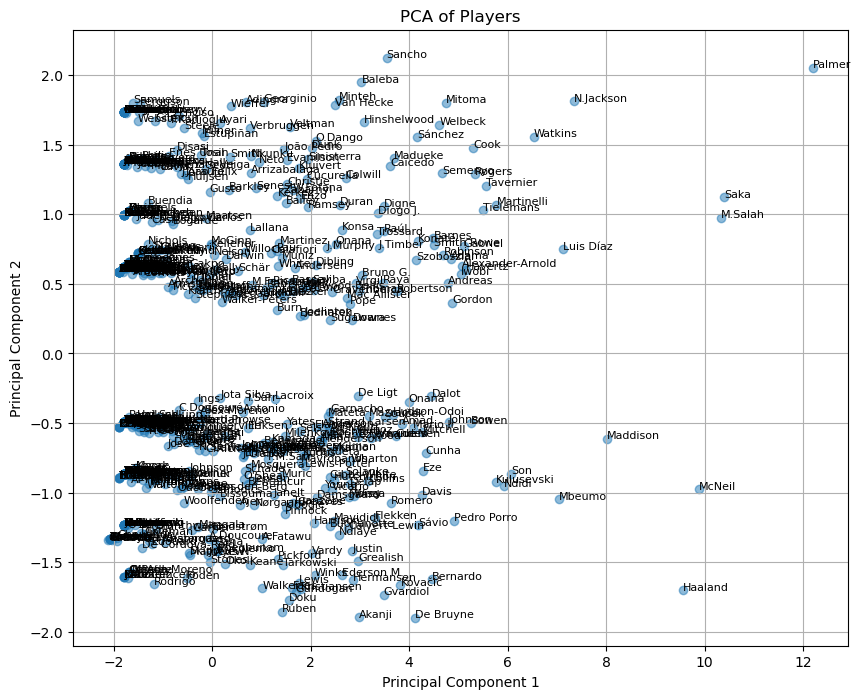

In [1297]:
import matplotlib.pyplot as plt

def visualize_pca(players_df):
    # Scatter plot of the first two PCA components
    plt.figure(figsize=(10, 8))
    plt.scatter(players_df['pca_1'], players_df['pca_2'], alpha=0.5)

    # Annotate each point with player names
    for i, row in players_df.iterrows():
        plt.annotate(row['web_name'], (row['pca_1'], row['pca_2']), fontsize=8)

    plt.title('PCA of Players')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid()
    plt.show()

# Call this function after you have the players_df from get_top_players_by_position()
visualize_pca(all_players)


In [1298]:

def get_current_gameweek():
    # FPL general information endpoint
    url = "https://fantasy.premierleague.com/api/bootstrap-static/"
    
    # Make the request to FPL API
    response = requests.get(url)
    
    # If the request is successful
    if response.status_code == 200:
        data = response.json()
        
        # Get the list of events (gameweeks)
        gameweeks = data['events']
        
        # Find the current gameweek
        current_gameweek = next((gw for gw in gameweeks if gw['is_current']), None)
        
        if current_gameweek:
            return current_gameweek['id']
        else:
            return "No current gameweek found."
    else:
        return f"Error: Unable to fetch data (status code {response.status_code})"

# Example usage
current_gw = get_current_gameweek()
print(f"Current Gameweek: {current_gw}")


Current Gameweek: 6


In [1299]:
def get_picks_for_gameweek(team_id, gw_number):
        # Construct the API URL
        url = f'https://fantasy.premierleague.com/api/entry/{team_id}/event/{gw_number}/picks/'
        
        # Make the request to the FPL API
        response = requests.get(url)
        
        if response.status_code == 200:
            picks_data = response.json()
            picks = pd.DataFrame(picks_data['picks'])  # Picks data
            return picks
        else:
            print(f"Failed to retrieve picks: {response.status_code}")
            return None

In [1300]:
def get_input_squad(myteam_id, gw_number):
    # Function to fetch the picks for a given team and gameweek

    # Fetch the player data and picks for a specific gameweek
    players_df, _ = get_player_data()  # Unpack the tuple here
    picks_df = get_picks_for_gameweek(team_id, gw_number)
    
    # Debug: Check if we have all 15 picks
    print("Picks DataFrame:", picks_df)
    
    # Extract important player details like name and ID from the player data
    player_details = players_df[['id', 'web_name']]
    
    # Merge the picks with player details using the 'element' (player ID)
    merged_df = pd.merge(picks_df, player_details, left_on='element', right_on='id', how='left')
    
    # Debug: Check if we are missing any players after the merge
    missing_players = picks_df[~picks_df['element'].isin(players_df['id'])]
    print("Missing Players (IDs not in players_df):", missing_players)
    
    # Create the list of player names and their IDs
    input_squad = merged_df[['id', 'web_name']]
    
    return input_squad

# Example usage
team_id = 3400878  # Your team ID
gw_number = get_current_gameweek()  # Gameweek number
input_squad = get_input_squad(team_id, gw_number)
print(input_squad)

Picks DataFrame:     element  position  multiplier  is_captain  is_vice_captain
0       185         1           1       False            False
1       311         2           1       False            False
2       355         3           1       False            False
3         3         4           1       False            False
4        78         5           1       False            False
5       327         6           1       False             True
6        17         7           1       False            False
7        99         8           1       False            False
8        82         9           1       False            False
9       220        10           1       False            False
10      351        11           2        True            False
11      521        12           0       False            False
12       54        13           0       False            False
13      162        14           0       False            False
14      270        15           0     

In [1301]:
input_squad.head()

,id,web_name
0,185,Sánchez
1,311,Alexander-Arnold
2,355,Lewis
3,3,Gabriel
4,78,Semenyo


In [1302]:
import pandas as pd
from IPython.display import display

def get_squad_stats(input_squad, player_df):
    # Filter player_df for players in the input squad
    squad_stats = player_df[player_df['id'].isin(input_squad['id'])]

    # Select relevant columns to display
    relevant_columns = ['id','ep_next', 'web_name', 'element_type', 'now_cost', 
                        'minutes', 'goals_scored', 'assists', 
                        'influence', 'points_per_game','points_per_game','selected_rank']
    
    # Create a new DataFrame with the relevant stats
    stats_to_display = squad_stats[relevant_columns]
    
   # Sort the DataFrame by 'now_cost'
    stats_to_display = stats_to_display.sort_values(by='now_cost', ascending=True)
    
    # Display the stats in table form
    display(stats_to_display)


# # Example usage
# team_id = 3400878  # Your team ID
# gw_number = get_current_gameweek()  # Gameweek number
# input_squad = get_input_squad(team_id, gw_number)  # Fetch the squad with IDs
# players_df, _ = get_player_data()  # Fetch the player data

# Call the function to display squad stats
get_squad_stats(input_squad, players_df)


,id,ep_next,web_name,element_type,now_cost,minutes,goals_scored,assists,influence,points_per_game,points_per_game,selected_rank
316,270,2.2,Greaves,2,40,540,0,0,125.2,1.8,1.8,71
607,521,0.5,Fabianski,1,40,45,0,0,16.4,1.0,1.0,21
185,162,4.3,Colwill,2,45,540,0,0,127.2,2.8,2.8,101
208,185,9.0,Sánchez,1,47,540,0,0,190.0,5.3,5.3,33
417,355,2.0,Lewis,2,47,395,0,1,75.4,3.4,3.4,32
58,54,6.3,Rogers,3,52,513,1,2,132.6,4.2,4.2,15
87,78,3.8,Semenyo,3,57,517,3,1,153.8,4.8,4.8,38
252,220,2.5,Calvert-Lewin,4,60,503,2,1,98.4,4.2,4.2,66
2,3,9.2,Gabriel,2,62,540,2,0,190.2,6.2,6.2,12
373,311,4.8,Alexander-Arnold,2,71,492,0,1,105.4,5.5,5.5,7


In [1303]:
import pandas as pd

def select_starting_11_and_bench(input_squad, players_df):
    """
    This function merges the input_squad with players_df to retrieve the required player details
    and then splits the squad into starting 11 and bench according to constraints.
    
    Bench constraints:
    - 1 goalkeeper at most
    - Maximum of 2 defenders
    - Maximum of 2 forwards
    - 4 players in total

    The lowest-cost players will be selected for the bench following these constraints.
    
    Parameters:
    input_squad (DataFrame): DataFrame containing 'id' and 'web_name' of selected players.
    players_df (DataFrame): DataFrame containing full player information, including 'id', 'element_type', 'now_cost'.
    
    Returns:
    tuple: (starting_11, bench) both as lists of player dictionaries.
    """
    players_df = get_players_data()
    # Merge input_squad with players_df on 'id' or 'web_name'
    merged_squad = pd.merge(input_squad, players_df, on='id', how='left')

    # Convert the merged DataFrame to a list of dictionaries for easier processing
    squad = merged_squad.to_dict(orient='records')

    # Separate players by position
    goalkeepers = [player for player in squad if player['element_type'] == 1]
    defenders = [player for player in squad if player['element_type'] == 2]
    midfielders = [player for player in squad if player['element_type'] == 3]
    forwards = [player for player in squad if player['element_type'] == 4]

    # Sort all players by 'now_cost' in ascending order
    sorted_squad = sorted(squad, key=lambda x: x['now_cost'])

    bench = []

    # Add 1 goalkeeper to the bench if available
    for player in sorted_squad:
        if len(bench) < 4 and player['element_type'] == 1 and sum(1 for p in bench if p['element_type'] == 1) < 1:
            bench.append(player)

    # Add up to 2 defenders to the bench
    for player in sorted_squad:
        if len(bench) < 4 and player['element_type'] == 2 and sum(1 for p in bench if p['element_type'] == 2) < 2:
            bench.append(player)

    # Add up to 2 forwards to the bench
    for player in sorted_squad:
        if len(bench) < 4 and player['element_type'] == 4 and sum(1 for p in bench if p['element_type'] == 4) < 2:
            bench.append(player)

    # If bench isn't full yet, fill remaining slots with midfielders
    for player in sorted_squad:
        if len(bench) < 4 and player['element_type'] == 3:
            bench.append(player)

    # Ensure the bench is exactly 4 players (if less, fill remaining with the next lowest cost players)
    while len(bench) < 4:
        for player in sorted_squad:
            if player not in bench:
                bench.append(player)
                break

    # Remaining players form the starting 11
    starting_11 = [player for player in squad if player not in bench]

    return starting_11, bench


# Example usage:
# input_squad = pd.DataFrame([{'id': 1, 'web_name': 'Player1'}, {'id': 2, 'web_name': 'Player2'}, ...])
# players_df = pd.DataFrame([...])  # Full player data containing 'id', 'element_type', 'now_cost'
starting_11, bench = select_starting_11_and_bench(input_squad, players_df)

# Display the results
print("Starting 11:")
for player in starting_11:
    print(f"{player['web_name_x']}")

print("\nBench:")
for player in bench:
    print(f"{player['web_name_x']}")


Starting 11:
Sánchez
Alexander-Arnold
Lewis
Gabriel
Semenyo
Luis Díaz
Saka
Mbeumo
Solanke
Haaland
Rogers

Bench:
Fabianski
Greaves
Colwill
Calvert-Lewin


In [1304]:
import pandas as pd

# Simulated players_df containing player information (ID and web_name)
# Replace this with your actual DataFrame with player data
players_df = get_player_data()

# Check if get_player_data() is returning a tuple, if so, access the correct element
if isinstance(players_df, tuple):
    players_df = players_df[0]  # Ensure players_df is now a DataFrame

def assign_bench_and_watch_avoid(input_squad):
    # Simulate top players by position (replace with your real data fetching function)
    top_goalkeepers, top_defenders, top_midfielders, top_forwards, _ = get_top_players_by_position()

    # Add a 'position' column to each DataFrame
    top_goalkeepers['position'] = 'Goalkeeper'
    top_defenders['position'] = 'Defender'
    top_midfielders['position'] = 'Midfielder'
    top_forwards['position'] = 'Forward'

    # Concatenate all players into a single DataFrame
    all_top_players = pd.concat([top_goalkeepers, top_defenders, top_midfielders, top_forwards], ignore_index=True)

    # Ensure columns 'influence' and 'now_cost' are numeric
    all_top_players['influence'] = pd.to_numeric(all_top_players['influence'], errors='coerce')
    all_top_players['now_cost'] = pd.to_numeric(all_top_players['now_cost'], errors='coerce')
    
    # Drop rows with NaN in 'influence' or 'now_cost'
    all_top_players.dropna(subset=['influence', 'now_cost'], inplace=True)

    # Keep players who are in both input squad and all_top_players
    keep = all_top_players[all_top_players['id'].isin(input_squad)]
    
    # Players in input_squad but not in the top players (watch/avoid)
    remaining_watch_avoid = [player for player in input_squad if player not in keep['id'].values]
    
    # Get player names for the remaining_watch_avoid list
    remaining_watch_avoid_names = players_df[players_df['id'].isin(remaining_watch_avoid)]
    
    # Return the final lists
    return keep, remaining_watch_avoid_names

def main():
    # Simulate the input squad (replace this with your actual squad)
    gw_number = get_current_gameweek()
    print(gw_number, team_id)
    
    input_squad = get_input_squad(team_id, gw_number)  # Assume it returns a DataFrame with player IDs
    # print("Input squad is: \n", input_squad)
    
    # Call the function to get players to keep and watch/avoid
    keep, watch_avoid = assign_bench_and_watch_avoid(input_squad['id'])
    
    # Display the relevant stats of players in 'keep' DataFrame
    print("Keep (Starting Squad):")
    print(keep[['id', 'web_name','pca_score']])  # Assuming 'web_name' exists in keep
    
    # For players to watch/avoid, display their names
    print("\nWatch/Avoid List (with player names):")
    print(watch_avoid[['id', 'web_name','now_cost', 'element_type']])  # Display the watch/avoid list with names

if __name__ == "__main__":
    main()


6 3400878
Picks DataFrame:     element  position  multiplier  is_captain  is_vice_captain
0       185         1           1       False            False
1       311         2           1       False            False
2       355         3           1       False            False
3         3         4           1       False            False
4        78         5           1       False            False
5       327         6           1       False             True
6        17         7           1       False            False
7        99         8           1       False            False
8        82         9           1       False            False
9       220        10           1       False            False
10      351        11           2        True            False
11      521        12           0       False            False
12       54        13           0       False            False
13      162        14           0       False            False
14      270        15       

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [1305]:
def get_picks_for_gameweek(team_id, gw_number):
        # Construct the API URL
        url = f'https://fantasy.premierleague.com/api/entry/{team_id}/event/{gw_number}/picks/'
        
        # Make the request to the FPL API
        response = requests.get(url)
        
        if response.status_code == 200:
            picks_data = response.json()
            picks = pd.DataFrame(picks_data['picks'])  # Picks data
            return picks
        else:
            print(f"Failed to retrieve picks: {response.status_code}")
            return None

In [1306]:
def calculate_transfer_budget(team_id, gw_number):
    # Function to fetch the picks for a given team and gameweek

    # Fetch the player data and picks for a specific gameweek
    players_df, _ = get_player_data()  # Unpack the tuple here
    picks_df = get_picks_for_gameweek(team_id, gw_number)
    
    # Extract important player details like name and ID from the player data
    player_details = players_df[['id', 'web_name','now_cost']]
    
    # Merge the picks with player details using the 'element' (player ID)
    merged_df = pd.merge(picks_df, player_details, left_on='element', right_on='id', how='left')
    # Calculate the total transfer budget
    transfer_budget = merged_df['now_cost'].sum() / 10  # now_cost is in tenths of millions, convert to millions
    return transfer_budget
    

In [1307]:
# Specify the team_id you want to get the transfer budget for
my_team_id = 3400878          
# Calculate the transfer budget for the specified team
transfer_budget = calculate_transfer_budget(my_team_id,gw_number)
print(f"Transfer budget for team ID {team_id}: £{transfer_budget:.2f} million")


Transfer budget for team ID 3400878: £100.60 million


In [1308]:
import pandas as pd
import requests

def get_team_info(team_id):
    # Construct the API URL for team details
    url = f'https://fantasy.premierleague.com/api/entry/{team_id}/'
    
    # Make the request to the FPL API
    response = requests.get(url)
    
    if response.status_code == 200:
        team_data = response.json()
        # print(team_data)  # Print the entire team data for inspection
        return team_data
    else:
        print(f"Failed to retrieve team info: {response.status_code}")
        return None

def get_free_transfers(team_id):
    team_info = get_team_info(team_id)
    
    if team_info is None:
        return None

    # Extract required fields from team_info
    last_deadline_bank = team_info.get('last_deadline_bank', 0)
    last_deadline_value = team_info.get('last_deadline_value', 0)  # This may not be needed for transfers
    last_deadline_total_transfers = team_info.get('last_deadline_total_transfers', 0)

    # print (current_gameweek)
    # Calculate available transfers
    current_gameweek = team_info.get('current_event', 0)
    available_transfers = current_gameweek - last_deadline_total_transfers
    
    
    # Return the calculated values
    return {
        'last_deadline_bank': last_deadline_bank,
        'available_transfers': available_transfers,
    }

# Specify the team_id for which you want to find the available free transfers
my_team_id = 3400878  # Replace with your team ID
current_gw = 6
# Get the number of free transfers available for the specified team
free_transfers_info = get_free_transfers(my_team_id)

if free_transfers_info is not None:
    print(f"Available free transfers for team ID {my_team_id}: {free_transfers_info['available_transfers']}")
    print(f"Available Budget: {free_transfers_info['last_deadline_bank']}")
else:
    print("Could not retrieve free transfers.")


Available free transfers for team ID 3400878: 1
Available Budget: 6


In [1309]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

def sort_by_intracluster_distance(watch_avoid):
    # Fetch data
    fixtures_df = get_fixtures()
    players_df = get_players_data()
    
    if players_df is None or fixtures_df is None:
        print("Failed to retrieve necessary data. Exiting.")
        return None

    # Get average FDR for each team
    average_fdr = calculate_average_fdr(fixtures_df)

    # Map team names back to their IDs
    team_mapping = {
            1: 'Arsenal', 2: 'Aston Villa', 3: 'Bournemouth', 4: 'Brentford',
            5: 'Brighton', 6: 'Chelsea', 7: 'Crystal Palace', 8: 'Everton',
            9: 'Fulham', 10: 'Ipswich', 11: 'Leicester', 12: 'Liverpool',
            13: 'Man City', 14: 'Man Utd', 15: 'Newcastle', 16: 'Nottingham Forest',
            17: 'Southampton', 18: 'Spurs', 19: 'West Ham', 20: 'Wolves'
    }
    
    average_fdr['team_name'] = average_fdr['team'].map(team_mapping)
    watch_avoid = watch_avoid.merge(average_fdr, how='left', left_on='team', right_on='team')
    
    # Define the features necessary for clustering
    feature_columns = ['ep_this', 'minutes', 'assists', 'bps', 'influence', 'creativity', 'ict_index', 'average_fdr']

    # Drop rows with missing data in the feature columns
    watch_avoid = watch_avoid.dropna(subset=feature_columns)

    # Convert features to numeric and drop any rows with invalid values
    X = watch_avoid[feature_columns].apply(pd.to_numeric, errors='coerce').dropna()

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply K-Means clustering (using 2 clusters as an example)
    kmeans = KMeans(n_clusters=2, random_state=42)
    watch_avoid['cluster'] = kmeans.fit_predict(X_scaled)

    # Function to calculate intracluster distance
    def calculate_intracluster_distance(cluster_data):
        distances = np.linalg.norm(cluster_data[:, np.newaxis] - cluster_data, axis=2)
        avg_distances = distances.mean(axis=1)
        return avg_distances

    # Add a cluster average distance column (renaming intracluster_distance)
    watch_avoid['cluster_avg_distance'] = np.nan
    for cluster in watch_avoid['cluster'].unique():
        cluster_data = X_scaled[watch_avoid['cluster'] == cluster]
        intracluster_distances = calculate_intracluster_distance(cluster_data)
        watch_avoid.loc[watch_avoid['cluster'] == cluster, 'cluster_avg_distance'] = intracluster_distances

    # Sort the DataFrame by 'cluster_avg_distance' in ascending order (lower distance is better)
    sorted_watch_avoid = watch_avoid.sort_values(by='cluster_avg_distance', ascending=True)

    # Add a ranking column (lower score gets a better rank)
    sorted_watch_avoid['rank'] = sorted_watch_avoid['cluster_avg_distance'].rank(method='min').astype(int)

    # Return only 'id', 'web_name', and 'rank' columns
    return sorted_watch_avoid[['id', 'web_name', 'rank','cluster_avg_distance']]

# Usage example
sorted_watch_avoid = sort_by_intracluster_distance(watch_avoid)
print(sorted_watch_avoid)


    id   web_name  rank  cluster_avg_distance
1   78    Semenyo     1              1.663332
0   54     Rogers     2              1.983437
4  355      Lewis     3              2.022110
2  162    Colwill     4              2.155817
3  270    Greaves     5              2.201877
5  521  Fabianski     6              2.679181


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [1310]:
def suggest_transfer(watch_avoid, top_goalkeepers, top_defenders, top_midfielders, top_forwards, available_budget, free_transfers):
    # Define position mapping
    position_map = {1: 'Goalkeeper', 2: 'Defender', 3: 'Midfielder', 4: 'Forward'}
    
    # Function to find replacement players from top players
    def find_replacement(player, top_players, available_budget):
        # Filter top players who are equal to or cheaper than (player's cost + available budget)
        affordable_players = top_players[top_players['now_cost'] <= (player['now_cost'] + available_budget)]
        if not affordable_players.empty:
            # Sort affordable players by lowest intracluster distance
            affordable_players = affordable_players.sort_values(by='intracluster_distance')
            # Return the best replacement (lowest intracluster distance)
            return affordable_players.iloc[0]
        return None

    # List to store suggested transfers
    suggested_transfers = []

    # Evaluate transfers based on free transfers available
    if free_transfers == 1:
        # Single transfer scenario
        for index, player in watch_avoid.iterrows():
            player_position = player['element_type']  # 1 for GK, 2 for DEF, etc.
            
            # Find corresponding top players for the same position
            if player_position == 1:
                top_players = top_goalkeepers
            elif player_position == 2:
                top_players = top_defenders
            elif player_position == 3:
                top_players = top_midfielders
            elif player_position == 4:
                top_players = top_forwards
            
            # Find a replacement player for the "avoid" player
            replacement = find_replacement(player, top_players, available_budget)
            if replacement is not None:
                suggested_transfers.append({
                    'sell': player['web_name'],
                    'buy': replacement['web_name'],
                    'position': position_map[player_position],
                    'sell_price': player['now_cost'],
                    'buy_price': replacement['now_cost']
                })
                break  # Only one transfer allowed in this case

    elif free_transfers >= 2:
        # Multiple transfers scenario, suggest two transfers
        for index, player in watch_avoid.iterrows():
            player_position = player['element_type']
            
            # Find corresponding top players for the same position
            if player_position == 1:
                top_players = top_goalkeepers
            elif player_position == 2:
                top_players = top_defenders
            elif player_position == 3:
                top_players = top_midfielders
            elif player_position == 4:
                top_players = top_forwards
            
            # Find a replacement player for the "avoid" player
            replacement = find_replacement(player, top_players, available_budget)
            if replacement is not None:
                suggested_transfers.append({
                    'sell': player['web_name'],
                    'buy': replacement['web_name'],
                    'position': position_map[player_position],
                    'sell_price': player['now_cost'],
                    'buy_price': replacement['now_cost']
                })
            
            if len(suggested_transfers) == free_transfers:
                break  # Stop when we have enough transfers

    if suggested_transfers:
        # Print out the suggested transfers
        for transfer in suggested_transfers:
            print(f"Suggesting Transfer: Sell {transfer['sell']} ({transfer['position']}) for {transfer['sell_price']/10}m")
            print(f"Buy {transfer['buy']} ({transfer['position']}) for {transfer['buy_price']/10}m\n")
    else:
        print("No suitable transfers found.")

# Usage Example:
available_budget = free_transfers_info['last_deadline_bank'] / 10  # Convert to millions if needed
free_transfers = free_transfers_info['available_transfers']
# free_transfers = 6
print(f"Since you have available free transfer of {free_transfers_info['available_transfers']} players and budget of {available_budget}, I suggest the following:")
suggest_transfer(watch_avoid, top_goalkeepers, top_defenders, top_midfielders, top_forwards, available_budget, free_transfers)


Since you have available free transfer of 1 players and budget of 0.6, I suggest the following:


KeyError: 'intracluster_distance'

In [ ]:
print("Or you can choose from the following alternatives:")
suggest_transfer(watch_avoid, top_goalkeepers, top_defenders, top_midfielders, top_forwards, available_budget, 5)


In [ ]:
# team_info = get_team_info(team_id)
# print(team_info)

In [ ]:
def main():
    # Simulate the input squad (replace this with your actual squad)
    team_id = 3400878          
    gw_number = get_current_gameweek()
    print(gw_number, team_id)
    
    input_squad = get_input_squad(team_id, gw_number) 
    # print("Input squad is: \n", input_squad)
    
    team_info = get_team_info(team_id)
    
    if team_info is None:
        return None

    # Extract required fields from team_info
    player_first_name = team_info.get('player_first_name', 0)
    player_last_name = team_info.get('player_last_name', 0)
    print("Welcome", player_first_name + "!")
        
    # Call the function to get players to keep and watch/avoid
    keep, watch_avoid = assign_bench_and_watch_avoid(input_squad['id'])
    
    # Sort 'keep' DataFrame by 'intracluster_distance' in ascending order
    sorted_keep = keep.sort_values(by='intracluster_distance', ascending=False)
    
    # Display the relevant stats of players in 'keep' DataFrame after sorting
    print("I like these players in your squad (sorted by intracluster distance):")
    print(sorted_keep[['id', 'web_name', 'intracluster_distance']])  # Assuming 'web_name' exists in keep

    print("Some of these players are bench players while some are risky.")

    # Sort the 'watch_avoid' DataFrame by 'intracluster_distance' and display
    sorted_watch_avoid = sort_by_intracluster_distance(watch_avoid)
    print(sorted_watch_avoid)
    
if __name__ == "__main__":
    main()
